# Chapter 7 – Ensemble Learning and Random Forests
Ensemble Learning : 분류기나 회귀 분석기와 같은 예측기들의 집계를 통해 예측하는 방법. 최상의 개별 예측기 한개 보다 더 나은 결과를 얻을 수 있다.<br>
Ensemble Method : 앙상블 학습 알고리즘<br>
Random Forest : Decision Tree 분류기를 여러개 사용하여 각각의 tree에서 얻어진 예측 중 가장 많은 vote 수를 받는 클래스를 예측한다.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

# 1. Voting classifiers
<img src='7-1.PNG'>
위 그림과 같이 Logistic Regression Classifier, SVM Classifier, Random Forest Classifier 등 각각 80%의 정확도를 가진 분류기를 훈련했다고 가정. <br>

이 각각의 예측 결과에서 가장 많은 vote 수를 가지는 클래스로 예측하면 더 좋은 분류기가 된다. <br>
이런 **Majority-Vote Classifier**는 **hard voting classifier**라고 불린다. <br>
충분히 다양하고 많은 학습기가 있다면 weak learner가 strong learner가 될 수 있다. 


In [10]:
heads_proba = 0.51
coin_tosses = (np.random.rand(100000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 100001).reshape(-1, 1)

 앞면이 나올 확률이 51%인 동전을 10개의 경우로 나타냈을 때 결과적으로 학습 횟수가 증가할수록 앞면이 나올 확률이 51%에 가까워 지는것을 알 수 있다. 

Saving figure law_of_large_numbers_plot


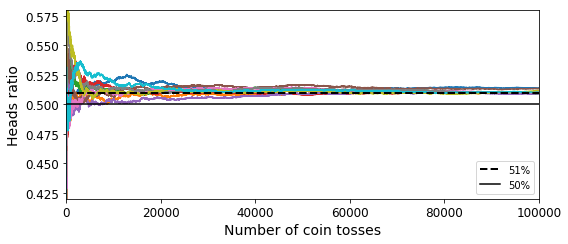

In [11]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 100000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 100000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 100000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

아래 코드는 Random Forest, Logist, SVM 분류기로 구성된 voting 분류기를 생성하여 학습시키는 것

### Hard voting
- 단순 투표. 개별 분류기의 결과를 나타냄

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

테스트에서 각 분류기의 정확도는 다음과 같다

In [15]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


Voting 분류기가 개별 분류기보다 정확도가 약간 더 높은 모습

### Soft voting 
- 모든 분류기가 클래스 확률을 예측할 수 있는 경우, 모든 개별 분류 기준에 대해 평균을 낸 클래스 확률이 가장 높은 클래스를 예측하는 것
- 즉, 가중치 투표. 개별 분류기의 조건부 확률의 합
- 확신하는 것에 대한 가중치를 높게 부여하여 hard voting보다 성과가 높게 나타난다.

In [16]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [17]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


# 2. Bagging and Pasting
같은 분류기를 사용하여 각각의 다른 training set의 subset에 적용시켜 학습하는 방법도 있다. <br>
- Bagging : 샘플링을 할 때 replacement로 수행하는 방법
- pasting : 샘플링 할 때 replacement가 없을 때<br>
즉 같은 데이터 샘플을 중복하여 사용하면 bagging, 중복하지 않으면 pasting

일반적으로 앙상블이 original 학습 set에서 학습된 개별 예측기와 bias는 비슷하지만 더 낮은 variance를 가진다. 

replacement 속성을 가진 학습 set<br>
무작위로 샘플링한 100개의 인스턴스로 학습<br>
500개의 의사결정 트리분류기를 앙상블로 학습

In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, #분류기 500개
    # sampling 데이터 100개, pasting을 원할 때는 bootstrap=False
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [21]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [22]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

c:\users\ejjch\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Saving figure decision_tree_without_and_with_bagging_plot


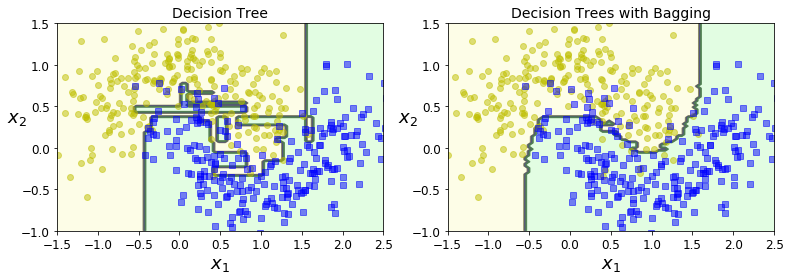

In [23]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Decision Tree의 의사결적 경계 VS 500개 트리로 앙상블 결절 경계를 나타낸 것<br>
앙상블의 예측이 더 일반적

## Out-of-Bag Evaluation
- bagging을 사용하면 일부 인스턴스들은 여러번 샘플링 될 수 있지만 다른인스턴스들은 전혀 샘플링 되지 않을 수 있다.
- 샘플링이 되지 않은 학습 인스턴스를 Out-of-Bag(oog)인스턴스라 한다.
- 즉 학습동안에 사용되지 않아 oob 인스턴스들은 평가에 이용될 수 있다. 
- 별도의 유효성 검증 set나 Cross-Validation이 필요없다. 
- oob 평가를 평균하여 앙상블을 평가 할 수 있다

In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, 
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40) # random_state숫자?
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.90133333333333332

In [25]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.912


oob 평가 점수와 별도의 test set를 통해 출력한 결과 (근접)

# 3. Random Patches and Random Subspaces
- Bagging Classifier 클래스는 feature 샘플링 지원.
- 두개의 파라미터 (max_features, bootstrap_features)에의해 제어된다. 
- 인스턴스 샘플링이 아닌 feature 샘플링을 수행하고 각 예측기는 입력 feature의 임의의 subset을 학습
- image와 같은 고차원 input값을 다룰때 유용하다.<br>
**Random Patches method** : 학습 인스턴스와 features 모두 샘플링하는 것<br>
**Random Subspaces method** : 학습 인스턴스는 유지하고 샘플링 feature로 하는 방식


# 4. Random Forests
- Decision Tree의 앙상블
- bagging method를 통해 학습되며 max_samples는 학습 set로 구성된다.(전체가 sample 수와 같음을 의미)
- Bagging classifier를 만들고 DecisionTreeClassifier를 전달하는 대신 RandomForestClassifier 클래스를 사용할 수 있다. 

Random Forest는 DecisionTreeClassifier(tree의 방향성?(grow)을 제어하기위해) 와 BaggingClassifier(앙상블 자체를 제어하기 위한)의 모든 하이퍼파라미터를 가진다. 

- Random Forest 알고리즘은 트리를 성장(growing)시킬때 무작위성을 지닌다. 
- random subset중에서 가장 좋은 feature를 찾는다
- tree의 다양성이 증가하여 bias를 높이는 대신 variance를 줄인다. 결과적으로 더 나은 모델을 생성

아래의 경우는 Bagging classifier를 만들고 DecisionTreeClassifier를 전달하는 코드

In [32]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [33]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

아래 코드는 500개의 트리를 가진 Random Forest 분류기를 학습시킨 것

In [34]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [35]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.97599999999999998

### Extra-Trees
Random Forest에서 트리 성장시킬 때, 노드에서 feature의 임의의 subset만 분할용으로 간주된다. <br>
가장 좋은 임계치를 결정하는 것보다 random 임계값을 설정하는 것이 tree를 더 random하게 한다. 

이러한 무작위적인 tree forest를 **Extremely Randomized Trees**라 한다. 
- 더 낮은 variance를 위해 bias는 커진다. 
- 일반적인 random forest의 경우 모든 노드에서 각 feature에 대한 최적의 임계값을 찾는 것이 트리 성장시 오래걸리는 작업이기 때문에 Exta-Trees의 경우 훨씬 더 빠르게 train이 가능하다. 

### Feature Importance
Random Forest는 각 feature 사이의 상대적 중요성을 측정할 수 있다는 장점이 있다. <br>
Scikit-learn은 해당 feature를 사용하는 트리 노드가 평균적으로 불순(impurity)을 줄일 수 있는지 살펴보고, feature의 중요성을 측정한다. 

Scikit-learn은 학습 후 각각의 feature에 점수를 부여하고 중요도 합이 1이 되도록 scaling 한다. <br>
이 중요도를 바탕으로 가장 중요한 항목을 알수 있다. 

In [36]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.112492250999
sepal width (cm) 0.0231192882825
petal length (cm) 0.441030464364
petal width (cm) 0.423357996355


In [37]:
rnd_clf.feature_importances_

array([ 0.11249225,  0.02311929,  0.44103046,  0.423358  ])

c:\users\ejjch\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


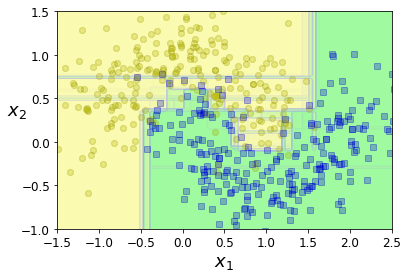

In [38]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

#### MNIST 데이터를 활용한 픽셀 중요도 학습

In [39]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [40]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [41]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


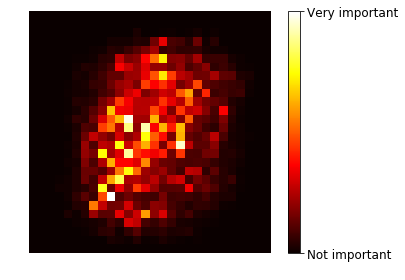

In [42]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# 5. Boosting 
- weak learners를 결합하여 strong learner로 되기 위한 앙상블 방법
- 이전 내용을 수정하면서 예측기를 순차적으로 학습시키는 것이 일반적


## AdaBoost
- 새로운 예측기의 predecessor를 수정하기 위해 under fitted된 predecessor의 학습 인스턴스에 주의를 기울인다. 
<img src='7-2.PNG'>
- 의사결정트리와 같은 첫번째 기본 분류기가 학습되고 잘못분류된 인스턴스의 weight는 증가한다. 
- 두번째는 업데이트된 weight를 이용하여 학습하고 다시 예측수행을 한 뒤 weight는 업데이트된다. 

In [43]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

c:\users\ejjch\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


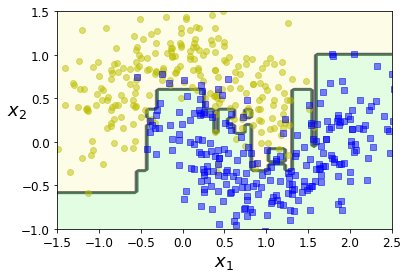

In [44]:
plot_decision_boundary(ada_clf, X, y)

c:\users\ejjch\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
c:\users\ejjch\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Saving figure boosting_plot


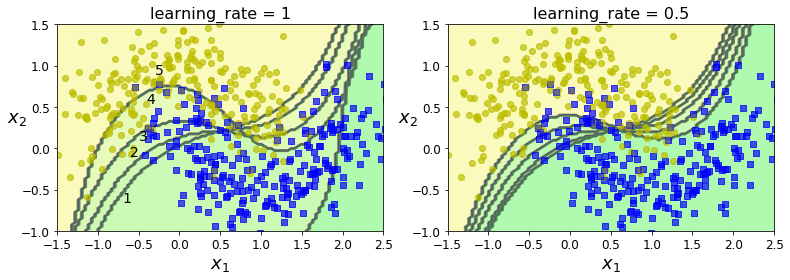

In [45]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)
save_fig("boosting_plot")
plt.show()

5개의 순차적 예측기를 통해 AdaBoost를 수행한 것.<br>

Gradient Descent와 유사하다. 


In [46]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

# Gradient Boosting
- AdaBoost와 마찬가지로 앙상블에 예측기를 순차적으로 추가하여 작동하면서 predecessor를 바로잡는다
- 모든 반복에서 인스턴스의 weight를 조정하는 AdaBoost와 달리 이전 예측기에 의해 생성된 잔차오류를 새로운 예측기에 맞춘다. 

**Gradient Tree Boosting OR Gradient Boosted Regression Trees(GBRT)**
- Decision Tree Regression을 학습 set에 맞춘다. 
- 데이터는 2차 학습데이터 사용

In [47]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

첫번째 예측기에 의한 잔차오류에 대한 두번째 Decision Tree Regression을 학습

In [49]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

두번째 예측기에 의한 잔차오류를 세번째 Regression에 학습

In [50]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

세개의 트리를 포함하는 앙상블 완성

In [51]:
X_new = np.array([[0.8]])

In [52]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [53]:
y_pred

array([ 0.75026781])

Saving figure gradient_boosting_plot


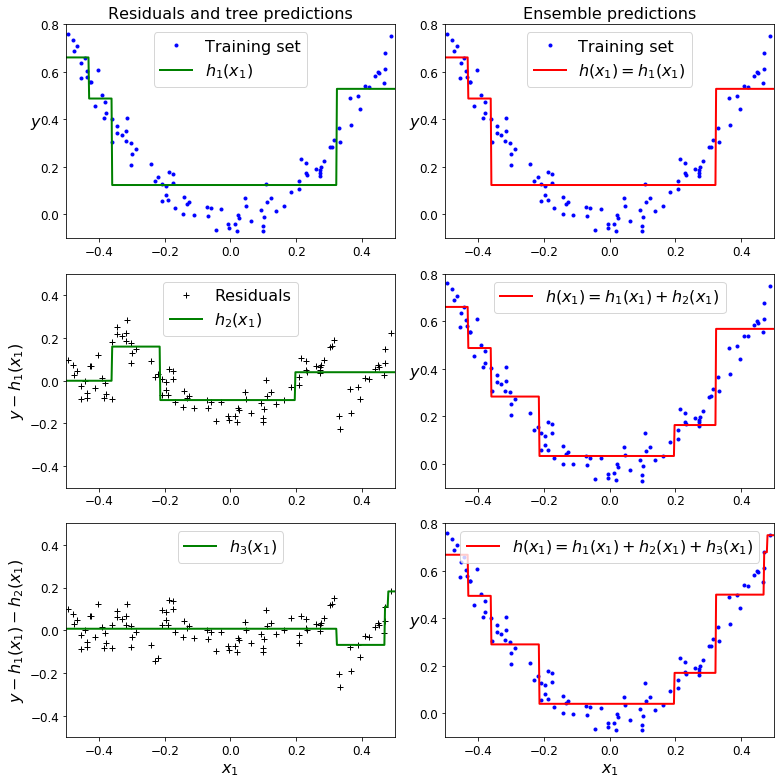

In [58]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

왼쪽열은 세가지 트리의 예측결과이고, 오른쪽열은 앙상블의 예측결과이다. <br>
첫번째열은 트리가 하나뿐이라 앙상블 결과와 일치하고 <br>
두번째열은 첫번째 트리의 잔차오류를 학습한 결과,<br>
세번째는 두번째 트리의 잔차오류를 학습한 결과로 점차 앙상블의 예측이 좋아진다.

In [59]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42) 
# max_depth, min_samples_leaf : tree growth 제어하는 매개변수, n_estimator : 트리의 수 제어하는 매개변수
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [60]:
gbrt.predict(X_new)

array([ 0.75026781])

위의 결과와 같다

In [61]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


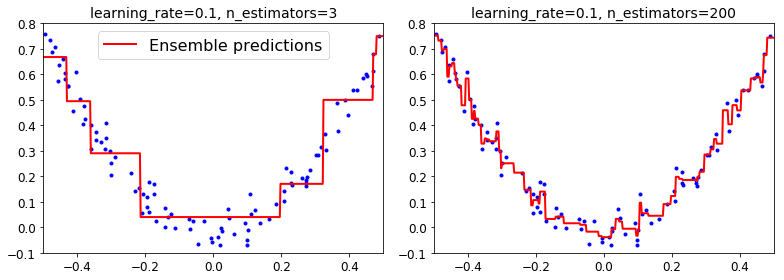

In [63]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

Learning rate는 트리의 contribution(기여도)을 조정한다. <br>
Shrinkage : 정규화 기업으로 LR를 0.1처럼 낮은 값으로 설정하여 예측을 잘되게 하는 방법. 학습 set에 맞게 더 많은 앙상블을 필요로 한다. 

왼쪽은 학습set 수가 너무 적고 오른쪽은 너무 많아 overfitting된 모습. 최적 값을 찾아야한다. (Early-stopping 사용)


## Gradient Boosting with Early stopping

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [65]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


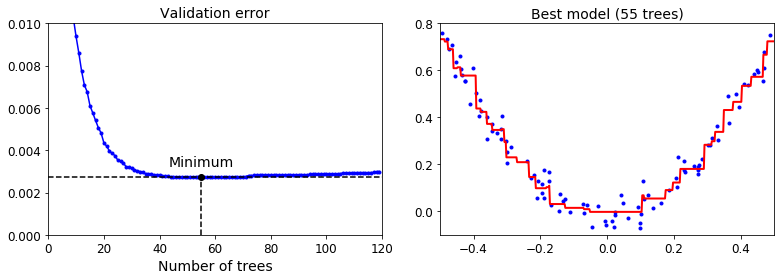

In [66]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

120개의 트리를 가진 GBRT 앙상블 훈련 시 Validation error를 측정하여 오류가 최소가 되는 트리 수를 찾는다.


In [67]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [68]:
print(gbrt.n_estimators)

61


# 5. Stacking 
 <img src='7-3.PNG'>
 앙상블의 예측 집계 과정을 모델로 수행하는 것으로 최종 예측기(Blender, meta learner)를 사용하여 최종 예측을 한다. 
 
 ### Blender 학습
 - Hold-out-set을 활용
  <img src='7-4.PNG'>
 1. 학습 set은 두개의 subset으로 나뉘고 첫번째 subset은 첫번째 layer의 예측기를 학습
  <img src='7-5.PNG'>
 2. 첫번째 layer의 예측기를 통해 두번째 set를 예측한다. 새로운 데이터에 대한 예측이 된다.
 3. 이 예측된 값을 입력 feature로 사용하여 새로운 학습 set를 만들고 target value를 유지한다. 
 4. Blender는 새로운 학습 set에 대해 학습되고, 첫번째 layer의 예측에서 주어진 target value를 예측하기 위해 학습한다. 
 
 이처럼 여러개의 다른 blender를 사용해서 학습이 가능한다. <br>
 Scikit-learn은 stacking을 직접 지원하지 않음